In [1]:
import os
from glob import glob
import random
import shutil
from tqdm import tqdm
import cv2
import numpy as np
import json

In [ ]:

dataset_root = "dataset"  

images_dir = os.path.join(dataset_root, "images")
masks_dir  = os.path.join(dataset_root, "masks")
labels_dir = os.path.join(dataset_root, "labels")  


class_map = None  


train_ratio = 0.8


dataset_yaml = os.path.join(dataset_root, "dataset.yaml")
# ----------------------------
os.makedirs(labels_dir, exist_ok=True)
print("Paths set:")
print(" images_dir:", images_dir)
print(" masks_dir:", masks_dir)
print(" labels_dir:", labels_dir)


Paths set:
 images_dir: dataset/images
 masks_dir: dataset/masks
 labels_dir: dataset/labels


In [ ]:

from google.colab import files

In [ ]:
def convert_masks_to_yolo(images_dir, masks_dir, labels_out_dir, class_map=None, min_area=10, save_empty=True):
 
    os.makedirs(labels_out_dir, exist_ok=True)
    img_paths = sorted(glob(os.path.join(images_dir, "*.*")))
    if len(img_paths) == 0:
        raise ValueError("No images found in images_dir: " + images_dir)

    for img_path in tqdm(img_paths, desc="Converting masks"):
        name = os.path.splitext(os.path.basename(img_path))[0]
       
        mask_path = None
        for ext in [".png", ".jpg", ".jpeg", ".tif", ".bmp"]:
            p = os.path.join(masks_dir, name + ext)
            if os.path.exists(p):
                mask_path = p
        
            if save_empty:
                open(os.path.join(labels_out_dir, name + ".txt"), "w").close()
            continue

        img = cv2.imread(img_path)
        h, w = img.shape[:2]
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            print(f"Warning: cannot read mask {mask_path}, skipping")
            if save_empty:
                open(os.path.join(labels_out_dir, name + ".txt"), "w").close()
            continue

        if mask.ndim == 3:
            mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        else:
            mask_gray = mask.copy()

        labels = []
        unique_vals = np.unique(mask_gray)
        for val in unique_vals:
            if int(val) == 0:
                continue
            val = int(val)
            if class_map is None:
                cls = 0
            else:
                cls = class_map.get(val, None)
                if cls is None:
                  
                    print(f"Mask value {val} not in class_map, skipping for image {name}")
                    continue
            bin_mask = (mask_gray == val).astype("uint8") * 255
            kernel = np.ones((3,3), np.uint8)
            bin_mask = cv2.morphologyEx(bin_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
            contours, _ = cv2.findContours(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                if cv2.contourArea(cnt) < min_area:
                    continue
                x, y, bw, bh = cv2.boundingRect(cnt)
                x_center = (x + bw/2) / w
                y_center = (y + bh/2) / h
                w_norm = bw / w
                h_norm = bh / h
                labels.append(f"{cls} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

        label_file = os.path.join(labels_out_dir, name + ".txt")
        with open(label_file, "w") as f:
            f.write("\n".join(labels))

        if len(labels) == 0 and save_empty:
            open(label_file, "w").close()


In [6]:
!ls -R dataset

dataset:
labels

dataset/labels:


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!ls /content/drive/MyDrive/datasets

'RGB-T wildfire dataset.zip'


In [10]:
zip_path = "/content/drive/MyDrive/datasets/RGB-T wildfire dataset.zip"
extract_dir = "/content/dataset"

!mkdir -p "{extract_dir}"
!unzip -q "{zip_path}" -d "{extract_dir}"

print("Done extracting!")

Done extracting!


In [11]:
!ls /content/dataset

 labels  'RGB-T wildfire dataset'


In [12]:
!ls "/content/dataset/RGB-T wildfire dataset"

C.txt  ground.txt	mask	    public.txt	test_day.txt
D.txt  instruction.txt	middle.txt  rgb		test_night.txt
F.txt  large.txt	nir	    small.txt


In [13]:
images_dir = "/content/dataset/RGB-T wildfire dataset/rgb"
masks_dir  = "/content/dataset/RGB-T wildfire dataset/mask"
labels_dir = "/content/dataset/labels"

print("Images exist:", len(os.listdir(images_dir)))
print("Masks exist:", len(os.listdir(masks_dir)))
print("Labels output:", labels_dir)

Images exist: 1367
Masks exist: 1367
Labels output: /content/dataset/labels


In [ ]:
def split_dataset(images_dir, labels_dir, out_root, train_ratio=0.8, seed=42):

    random.seed(seed)
    os.makedirs(out_root, exist_ok=True)
    train_img_dir = os.path.join(out_root, "train", "images")
    train_lbl_dir = os.path.join(out_root, "train", "labels")
    val_img_dir = os.path.join(out_root, "val", "images")
    val_lbl_dir = os.path.join(out_root, "val", "labels")
    for d in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
        os.makedirs(d, exist_ok=True)

    img_paths = sorted(glob(os.path.join(images_dir, "*.*")))
    names = [os.path.splitext(os.path.basename(p))[0] for p in img_paths]
    random.shuffle(names)
    n_train = int(len(names) * train_ratio)
    train_names = set(names[:n_train])
    val_names = set(names[n_train:])

    def copy_set(names_set, img_out_dir, lbl_out_dir):
        for name in names_set:
        
            found_img = None
            for ext in [".jpg", ".jpeg", ".png", ".bmp", ".tif"]:
                p = os.path.join(images_dir, name + ext)
                if os.path.exists(p):
                    found_img = p
                    break
            if found_img:
                shutil.copy(found_img, os.path.join(img_out_dir, os.path.basename(found_img)))
        
            label_file_src = os.path.join(labels_dir, name + ".txt")
            if os.path.exists(label_file_src):
                shutil.copy(label_file_src, os.path.join(lbl_out_dir, name + ".txt"))
            else:
               
                open(os.path.join(lbl_out_dir, name + ".txt"), "w").close()

    copy_set(train_names, train_img_dir, train_lbl_dir)
    copy_set(val_names, val_img_dir, val_lbl_dir)
    print(f"Train items: {len(train_names)}, Val items: {len(val_names)}")
    return {
        "train_images": train_img_dir,
        "train_labels": train_lbl_dir,
        "val_images": val_img_dir,
        "val_labels": val_lbl_dir
    }

out_root = os.path.join(dataset_root, "yolo_dataset")
paths = split_dataset(images_dir, labels_dir, out_root, train_ratio=train_ratio)
paths


Train items: 1093, Val items: 274


{'train_images': 'dataset/yolo_dataset/train/images',
 'train_labels': 'dataset/yolo_dataset/train/labels',
 'val_images': 'dataset/yolo_dataset/val/images',
 'val_labels': 'dataset/yolo_dataset/val/labels'}

In [ ]:

if class_map is None:
    nc = 1
    names = ["object"]
else:
  
    unique_class_indices = sorted(set(class_map.values()))
    nc = max(unique_class_indices) + 1
 
    names = [f"class{i}" for i in range(nc)]

yaml_content = {
    "path": os.path.abspath(out_root),
    "train": "train/images",
    "val": "val/images",
    "test": "val/images",
    "nc": nc,
    "names": names
}

with open(dataset_yaml, "w") as f:
    import yaml
    yaml.dump(yaml_content, f)

print("Created dataset.yaml at:", dataset_yaml)
print(yaml_content)


Created dataset.yaml at: dataset/dataset.yaml
{'path': '/content/dataset/yolo_dataset', 'train': 'train/images', 'val': 'val/images', 'test': 'val/images', 'nc': 1, 'names': ['object']}


In [1]:
!pip install torch==2.2.0 torchvision==0.17.0 --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install ultralytics==8.2.103

In [3]:
import torch
print(torch.__version__)

2.2.0+cu118


In [ ]:
with open("dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml created!")

dataset.yaml created!


In [7]:
!ls /content/dataset/yolo_dataset

train  val


In [25]:
!cat ~/.config/Ultralytics/settings.yaml


settings_version: 0.0.4
datasets_dir: /content/datasets
weights_dir: weights
runs_dir: runs
uuid: 569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb
sync: true
api_key: ''
clearml: true
comet: true
dvc: true
hub: true
mlflow: true
neptune: true
raytune: true
tensorboard: true
wandb: true
use_wandb: false


In [1]:
!ls /usr/local/lib/python3.12/dist-packages/ultralytics/utils/callbacks/


base.py     comet.py  hub.py	   mlflow.py   __pycache__  tensorboard.py
clearml.py  dvc.py    __init__.py  neptune.py  raytune.py


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

results = model.train(
    data="coco8.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    name="test_training"
)

New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.2.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco8.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=test_training, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 

100%|██████████| 433k/433k [00:00<00:00, 113MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100%|██████████| 25/25 [00:00<00:00, 4393.05file/s]

Dataset download success ✅ (0.7s), saved to /content/datasets


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1 

Model summary: 225 layers, 3,157,200 parameters, 3,157,184 gradients, 8.9 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /content/datasets/coco8/labels/train... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 1156.89it/s]

train: New cache created: /content/datasets/coco8/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 855.37it/s]

val: New cache created: /content/datasets/coco8/labels/val.cache


Plotting labels to runs/detect/test_training/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/test_training
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.69G      1.039      2.062      1.348         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all          4         17       0.63      0.873      0.888      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.998G      1.003      2.825      1.328         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]

                   all          4         17      0.616      0.895      0.888      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.992G      1.018      2.897      1.401         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]

                   all          4         17      0.633      0.878      0.888      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.992G     0.9069      2.494      1.208         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]

                   all          4         17      0.567      0.843      0.874      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.992G     0.9033       2.39      1.219         13        640: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.79it/s]

                   all          4         17      0.548      0.833      0.874      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.02G     0.9512      2.078      1.275         13        640: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.93it/s]

                   all          4         17      0.547      0.833      0.874      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.02G      1.069      2.777      1.438         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.34it/s]

                   all          4         17      0.619      0.833      0.893      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.02G      1.063      2.122      1.255         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]

                   all          4         17      0.635       0.75      0.893       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.02G     0.9886      1.466      1.317         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.66it/s]

                   all          4         17      0.638       0.75      0.893      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.02G     0.8234      1.759      1.167         13        640: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.86it/s]

                   all          4         17      0.916      0.567      0.829      0.607



10 epochs completed in 0.031 hours.
Optimizer stripped from runs/detect/test_training/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/test_training/weights/best.pt, 6.5MB

Validating runs/detect/test_training/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.2.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 31.38it/s]


                   all          4         17       0.64       0.75      0.894       0.63
                person          3         10      0.568        0.5      0.557        0.3
                   dog          1          1      0.346          1      0.995      0.697
                 horse          1          2      0.674          1      0.995      0.697
              elephant          1          2          1          0      0.828      0.197
              umbrella          1          1      0.535          1      0.995      0.995
          potted plant          1          1      0.716          1      0.995      0.895
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/test_training


In [ ]:
from pathlib import Path
import os

def check_my_dataset():
    dataset_path = "dataset.yaml"
    if not os.path.exists(dataset_path):
        print(f"❌ {dataset_path} غير موجود!")
        return False

    print(f"✅ {dataset_path} موجود")

    with open(dataset_path, 'r') as f:
        content = f.read()
        print("محتوى dataset.yaml:")
        print(content)
        print("-" * 50)

    paths_to_check = [
        "dataset/yolo_dataset/train/images",
        "dataset/yolo_dataset/train/labels",
        "dataset/yolo_dataset/val/images",
        "dataset/yolo_dataset/val/labels"
    ]

    for path in paths_to_check:
        if os.path.exists(path):
            files = os.listdir(path)
            print(f"✅ {path}: {len(files)} ملف")
            if files:
                print(f"   أمثلة: {files[:3]}")  
        else:
            print(f"❌ {path} غير موجود!")
        print("-" * 30)

    return True

check_my_dataset()

✅ dataset.yaml موجود
محتوى dataset.yaml:

path: /content/dataset/yolo_dataset   # عدّل حسب مسارك

train: train/images
val: val/images

names:
  0: fire

--------------------------------------------------
✅ dataset/yolo_dataset/train/images: 1093 ملف
   أمثلة: ['58E_gt.png', '179_gt.png', '519E_gt.png']
------------------------------
✅ dataset/yolo_dataset/train/labels: 1093 ملف
   أمثلة: ['167E_gt.txt', '186A_gt.txt', '150_gt.txt']
------------------------------
✅ dataset/yolo_dataset/val/images: 274 ملف
   أمثلة: ['412E_gt.png', '120E_gt.png', '561E_gt.png']
------------------------------
✅ dataset/yolo_dataset/val/labels: 274 ملف
   أمثلة: ['36E_gt.txt', '140F_gt.txt', '357_gt.txt']
------------------------------


True

In [ ]:
def create_auto_labels():
    def process_image_for_fire_detection(image_path):
        try:
            img = cv2.imread(image_path)
            if img is None:
                return None

            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            lower_fire1 = np.array([0, 100, 100])
            upper_fire1 = np.array([10, 255, 255])
            lower_fire2 = np.array([160, 100, 100])
            upper_fire2 = np.array([180, 255, 255])

            mask1 = cv2.inRange(hsv, lower_fire1, upper_fire1)
            mask2 = cv2.inRange(hsv, lower_fire2, upper_fire2)
            fire_mask = mask1 + mask2

            contours, _ = cv2.findContours(fire_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            bboxes = []
            for contour in contours:
                if cv2.contourArea(contour) > 100:
                    x, y, w, h = cv2.boundingRect(contour)
                    x_center = (x + w/2) / img.shape[1]
                    y_center = (y + h/2) / img.shape[0]
                    width = w / img.shape[1]
                    height = h / img.shape[0]

                    bboxes.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

            return bboxes

        except Exception as e:
            print(f"خطأ في معالجة {image_path}: {e}")
            return None

    image_dirs = [
        "dataset/yolo_dataset/train/images",
        "dataset/yolo_dataset/val/images"
    ]

    label_dirs = [
        "dataset/yolo_dataset/train/labels",
        "dataset/yolo_dataset/val/labels"
    ]

    total_created = 0

    for img_dir, label_dir in zip(image_dirs, label_dirs):
        if os.path.exists(img_dir):
            image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
            print(f"🔍 معالجة {len(image_files)} صورة في {img_dir}")

            for i, img_file in enumerate(image_files[:50]): 
                if i % 10 == 0:
                    print(f"   معالجة الصورة {i+1}/{min(50, len(image_files))}")

                img_path = os.path.join(img_dir, img_file)
                label_path = os.path.join(label_dir, img_file.replace('.png', '.txt').replace('.jpg', '.txt'))

                bboxes = process_image_for_fire_detection(img_path)

                if bboxes:
                    with open(label_path, 'w') as f:
                        for bbox in bboxes:
                            f.write(bbox + '\n')
                    total_created += 1

    print(f"✅ تم إنشاء {total_created} تسمية تلقائية")
    return total_created
if annotation_source is None:
    created_count = create_auto_labels()

🔍 معالجة 1093 صورة في dataset/yolo_dataset/train/images
   معالجة الصورة 1/50
   معالجة الصورة 11/50
   معالجة الصورة 21/50
   معالجة الصورة 31/50
   معالجة الصورة 41/50
🔍 معالجة 274 صورة في dataset/yolo_dataset/val/images
   معالجة الصورة 1/50
   معالجة الصورة 11/50
   معالجة الصورة 21/50
   معالجة الصورة 31/50
   معالجة الصورة 41/50
✅ تم إنشاء 74 تسمية تلقائية


In [ ]:

def complete_label_recreation():

    def clear_all_labels():
        label_dirs = [
            "dataset/yolo_dataset/train/labels",
            "dataset/yolo_dataset/val/labels"
        ]

        cleared_count = 0
        for label_dir in label_dirs:
            if os.path.exists(label_dir):
                label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
                for label_file in label_files:
                    file_path = os.path.join(label_dir, label_file)
                    os.remove(file_path)
                    cleared_count += 1

        print(f"🗑️  تم مسح {cleared_count} ملف تسمية قديم")
        return cleared_count

    def enhanced_fire_detection(image_path):
        """كشف محسن لمناطق النار"""
        try:
            img = cv2.imread(image_path)
            if img is None:
                return None

         
            scale = 0.5
            small_img = cv2.resize(img, (0,0), fx=scale, fy=scale)

         
            hsv = cv2.cvtColor(small_img, cv2.COLOR_BGR2HSV)
            lab = cv2.cvtColor(small_img, cv2.COLOR_BGR2LAB)

        
            lower_red1 = np.array([0, 100, 100])
            upper_red1 = np.array([15, 255, 255])
            mask1 = cv2.inRange(hsv, lower_red1, upper_red1)

           
            lower_red2 = np.array([160, 100, 100])
            upper_red2 = np.array([180, 255, 255])
            mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

         
            lower_orange = np.array([15, 100, 100])
            upper_orange = np.array([30, 255, 255])
            mask3 = cv2.inRange(hsv, lower_orange, upper_orange)

        
            lower_bright = np.array([0, 0, 150])
            upper_bright = np.array([255, 128, 255])
            mask4 = cv2.inRange(lab, lower_bright, upper_bright)

            
            fire_mask = mask1 + mask2 + mask3 + mask4

            kernel = np.ones((7,7), np.uint8)
            fire_mask = cv2.morphologyEx(fire_mask, cv2.MORPH_CLOSE, kernel)
            fire_mask = cv2.morphologyEx(fire_mask, cv2.MORPH_OPEN, kernel)


            contours, _ = cv2.findContours(fire_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            bboxes = []
            for contour in contours:
                area = cv2.contourArea(contour)
                if area > 100:  
                    x, y, w, h = cv2.boundingRect(contour)

                  
                    x, y, w, h = int(x/scale), int(y/scale), int(w/scale), int(h/scale)

                   
                    x_center = (x + w/2) / img.shape[1]
                    y_center = (y + h/2) / img.shape[0]
                    width = w / img.shape[1]
                    height = h / img.shape[0]

                   
                    if (0 <= x_center <= 1 and 0 <= y_center <= 1 and
                        0.01 <= width <= 0.8 and 0.01 <= height <= 0.8):
                        bboxes.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

            return bboxes

        except Exception as e:
            print(f"   خطأ في {os.path.basename(image_path)}: {e}")
            return None

   
    clear_all_labels()

 
    image_dirs = ["dataset/yolo_dataset/train/images", "dataset/yolo_dataset/val/images"]
    label_dirs = ["dataset/yolo_dataset/train/labels", "dataset/yolo_dataset/val/labels"]

    total_created = 0

    for img_dir, label_dir in zip(image_dirs, label_dirs):
        if not os.path.exists(img_dir):
            continue

        
        os.makedirs(label_dir, exist_ok=True)

        image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        print(f"🔍 معالجة {len(image_files)} صورة في {img_dir}")

        created_in_dir = 0
        for i, img_file in enumerate(image_files):
            if i % 50 == 0 and i > 0:
                print(f"   ⏳ معالجة الصورة {i}/{len(image_files)}...")

            img_path = os.path.join(img_dir, img_file)
            label_file = img_file.rsplit('.', 1)[0] + '.txt'
            label_path = os.path.join(label_dir, label_file)

            bboxes = enhanced_fire_detection(img_path)

            if bboxes:
                try:
                    with open(label_path, 'w', encoding='utf-8') as f:
                        for bbox in bboxes:
                            f.write(bbox + '\n')

                    if os.path.exists(label_path):
                        with open(label_path, 'r', encoding='utf-8') as f:
                            if f.read().strip():
                                total_created += 1
                                created_in_dir += 1
                except Exception as e:
                    print(f"   ❌ خطأ في حفظ {label_file}: {e}")

        print(f"   ✅ تم إنشاء {created_in_dir} تسمية في {label_dir}")

    print(f"\n🎉 الإجمالي النهائي: تم إنشاء {total_created} تسمية بنجاح!")
    return total_created


final_count = complete_label_recreation()

🗑️  تم مسح 1794 ملف تسمية قديم
🔍 معالجة 1093 صورة في dataset/yolo_dataset/train/images
   ⏳ معالجة الصورة 50/1093...
   ⏳ معالجة الصورة 100/1093...
   ⏳ معالجة الصورة 150/1093...
   ⏳ معالجة الصورة 200/1093...
   ⏳ معالجة الصورة 250/1093...
   ⏳ معالجة الصورة 300/1093...
   ⏳ معالجة الصورة 350/1093...
   ⏳ معالجة الصورة 400/1093...
   ⏳ معالجة الصورة 450/1093...
   ⏳ معالجة الصورة 500/1093...
   ⏳ معالجة الصورة 550/1093...
   ⏳ معالجة الصورة 600/1093...
   ⏳ معالجة الصورة 650/1093...
   ⏳ معالجة الصورة 700/1093...
   ⏳ معالجة الصورة 750/1093...
   ⏳ معالجة الصورة 800/1093...
   ⏳ معالجة الصورة 850/1093...
   ⏳ معالجة الصورة 900/1093...
   ⏳ معالجة الصورة 950/1093...
   ⏳ معالجة الصورة 1000/1093...
   ⏳ معالجة الصورة 1050/1093...
   ✅ تم إنشاء 759 تسمية في dataset/yolo_dataset/train/labels
🔍 معالجة 274 صورة في dataset/yolo_dataset/val/images
   ⏳ معالجة الصورة 50/274...
   ⏳ معالجة الصورة 100/274...
   ⏳ معالجة الصورة 150/274...
   ⏳ معالجة الصورة 200/274...
   ⏳ معالجة الصورة 250/274..

In [ ]:
def comprehensive_verification():
    print("\n🔍 التحقق الشامل النهائي...")

    label_dirs = ["dataset/yolo_dataset/train/labels", "dataset/yolo_dataset/val/labels"]

    total_files = 0
    total_non_empty = 0
    total_bboxes = 0

    for label_dir in label_dirs:
        if os.path.exists(label_dir):
            label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
            total_files += len(label_files)

            non_empty_count = 0
            bboxes_count = 0

            for label_file in label_files:
                full_path = os.path.join(label_dir, label_file)
                try:
                    with open(full_path, 'r', encoding='utf-8') as f:
                        content = f.read().strip()
                        if content:
                            non_empty_count += 1
                            bboxes_count += len(content.split('\n'))

                            if non_empty_count <= 2:  # عرض أول ملفين غير فارغين
                                print(f"   ✅ {label_file}:")
                                lines = content.split('\n')
                                for j, line in enumerate(lines[:2]):
                                    print(f"      {line}")
                except Exception as e:
                    continue

            total_non_empty += non_empty_count
            total_bboxes += bboxes_count

            print(f"\n📊 {label_dir}:")
            print(f"   📁 إجمالي الملفات: {len(label_files)}")
            print(f"   ✅ الملفات غير الفارغة: {non_empty_count}")
            print(f"   🔲 إجمالي BBoxes: {bboxes_count}")
            if len(label_files) > 0:
                print(f"   📈 نسبة النجاح: {(non_empty_count/len(label_files))*100:.1f}%")
            print("-" * 50)

    print(f"\n🎯 الإحصائيات النهائية:")
    print(f"   📁 إجمالي ملفات التسميات: {total_files}")
    print(f"   ✅ إجمالي الملفات غير الفارغة: {total_non_empty}")
    print(f"   🔲 إجمالي BBoxes المكتشفة: {total_bboxes}")

    if total_files > 0:
        success_rate = (total_non_empty / total_files) * 100
        print(f"   📈 نسبة النجاح الإجمالية: {success_rate:.1f}%")

        if success_rate >= 30:  
            print("   🚀 جاهز للتدريب!")
            return True
        else:
            print("   ⚠️ تحتاج إلى المزيد من التسميات للتدريب الجيد")
            return False
    else:
        print("   ❌ لا توجد ملفات تسميات")
        return False

ready_for_training = comprehensive_verification()


🔍 التحقق الشامل النهائي...
   ✅ 167E_gt.txt:
      0 0.478125 0.447266 0.287500 0.167969
   ✅ 186A_gt.txt:
      0 0.215625 0.662109 0.037500 0.066406
      0 0.287500 0.166016 0.056250 0.082031

📊 dataset/yolo_dataset/train/labels:
   📁 إجمالي الملفات: 759
   ✅ الملفات غير الفارغة: 759
   🔲 إجمالي BBoxes: 1763
   📈 نسبة النجاح: 100.0%
--------------------------------------------------
   ✅ 140F_gt.txt:
      0 0.251563 0.314453 0.046875 0.066406
   ✅ 357_gt.txt:
      0 0.702381 0.500000 0.090476 0.104762
      0 0.369048 0.171429 0.071429 0.171429

📊 dataset/yolo_dataset/val/labels:
   📁 إجمالي الملفات: 189
   ✅ الملفات غير الفارغة: 189
   🔲 إجمالي BBoxes: 445
   📈 نسبة النجاح: 100.0%
--------------------------------------------------

🎯 الإحصائيات النهائية:
   📁 إجمالي ملفات التسميات: 948
   ✅ إجمالي الملفات غير الفارغة: 948
   🔲 إجمالي BBoxes المكتشفة: 2208
   📈 نسبة النجاح الإجمالية: 100.0%
   🚀 جاهز للتدريب!


In [ ]:
from ultralytics import YOLO
import time

def start_final_training():

    print("\n🚀 Starting Final Training with 948 Labels...")
    print("📊 Final Statistics:")
    print("   🎯 759 training images + 189 validation images")
    print("   🔲 2208 fire regions detected")
    print("   ✅ 100% success rate in label creation")
    print("⏳ This may take 20-60 minutes...")

    start_time = time.time()

    try:
    
        model = YOLO("yolov8n.pt")

      
        results = model.train(
            data="dataset.yaml",
            epochs=100,         
            imgsz=640,
            batch=16,
            patience=25,          
            lr0=0.001,          
            lrf=0.01,          
            momentum=0.937,
            weight_decay=0.0005,
            warmup_epochs=3.0,   
            box=7.5,           
            cls=0.5,
            dfl=1.5,
            verbose=True,
            save=True,
            save_period=20,      
            cache=False,
            name="fire_detection_final",
            pretrained=True,
            optimizer='auto',
            seed=42,
            deterministic=True,
            single_cls=True,     
            rect=False,
            cos_lr=False,
            close_mosaic=10,
            overlap_mask=True,
            mask_ratio=4,
            dropout=0.0,
            val=True,
            plots=True,          
            exist_ok=True        
        )

        end_time = time.time()
        training_duration = (end_time - start_time) / 60
        print(f"✅ ✅ ✅ Training completed successfully in {training_duration:.1f} minutes!")

       
        if hasattr(results, 'results_dict'):
            print("\n📊 Detailed Training Results:")
            print("   LOSS METRICS:")
            print(f"   📍 Box Loss: {results.results_dict.get('train/box_loss', 'N/A'):.4f}")
            print(f"   📍 Classification Loss: {results.results_dict.get('train/cls_loss', 'N/A'):.4f}")
            print(f"   📍 DFL Loss: {results.results_dict.get('train/dfl_loss', 'N/A'):.4f}")
            print(f"   📍 Validation Box Loss: {results.results_dict.get('val/box_loss', 'N/A'):.4f}")
            print(f"   📍 Validation Classification Loss: {results.results_dict.get('val/cls_loss', 'N/A'):.4f}")

            print("\n   PERFORMANCE METRICS:")
            print(f"   📍 Precision: {results.results_dict.get('metrics/precision(B)', 'N/A'):.4f}")
            print(f"   📍 Recall: {results.results_dict.get('metrics/recall(B)', 'N/A'):.4f}")
            print(f"   📍 mAP50: {results.results_dict.get('metrics/mAP50(B)', 'N/A'):.4f}")
            print(f"   📍 mAP50-95: {results.results_dict.get('metrics/mAP50-95(B)', 'N/A'):.4f}")

            
            if 'stop_epoch' in results.results_dict:
                print(f"\n   🛑 EARLY STOPPING:")
                print(f"   📍 Stopped at epoch: {results.results_dict['stop_epoch']}/100")
                print(f"   📍 Best mAP50: {results.results_dict.get('best_map', 'N/A'):.4f}")

        return True

    except Exception as e:
        print(f"❌ Training failed: {e}")
        return False

training_success = start_final_training()


🚀 Starting Final Training with 948 Labels...
📊 Final Statistics:
   🎯 759 training images + 189 validation images
   🔲 2208 fire regions detected
   ✅ 100% success rate in label creation
⏳ This may take 20-60 minutes...
New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.2.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=100, time=None, patience=25, batch=16, imgsz=640, save=True, save_period=20, cache=False, device=None, workers=8, project=None, name=fire_detection_final, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=Fals

train: Scanning /content/dataset/yolo_dataset/train/labels... 759 images, 334 backgrounds, 0 corrupt: 100%|██████████| 1093/1093 [00:03<00:00, 346.84it/s]

train: New cache created: /content/dataset/yolo_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/dataset/yolo_dataset/val/labels... 189 images, 85 backgrounds, 0 corrupt: 100%|██████████| 274/274 [00:00<00:00, 290.61it/s]

val: New cache created: /content/dataset/yolo_dataset/val/labels.cache


Plotting labels to runs/detect/fire_detection_final/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/fire_detection_final
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.45G      2.295      3.849      1.962         16        640: 100%|██████████| 69/69 [00:07<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.08it/s]

                   all        274        445      0.551     0.0742     0.0909     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.46G       2.15      3.062      1.768         21        640: 100%|██████████| 69/69 [00:06<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.90it/s]

                   all        274        445      0.298      0.175       0.14     0.0605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.46G      2.168       2.81      1.794         20        640: 100%|██████████| 69/69 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.65it/s]

                   all        274        445      0.189      0.178      0.128     0.0524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.45G      2.163       2.78      1.766         11        640: 100%|██████████| 69/69 [00:06<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


                   all        274        445      0.326      0.166      0.133     0.0508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.44G      2.051      2.563      1.682          8        640: 100%|██████████| 69/69 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.98it/s]


                   all        274        445      0.407      0.279      0.246      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.46G      1.987      2.429      1.654          9        640: 100%|██████████| 69/69 [00:06<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.99it/s]


                   all        274        445      0.455      0.256       0.28      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.45G      1.913      2.291       1.61          4        640: 100%|██████████| 69/69 [00:06<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.54it/s]

                   all        274        445      0.457      0.234      0.244      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.45G      1.908      2.286      1.601         10        640: 100%|██████████| 69/69 [00:06<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.11it/s]


                   all        274        445      0.479      0.261      0.284      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.44G      1.898       2.26      1.612          8        640: 100%|██████████| 69/69 [00:06<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.47it/s]


                   all        274        445      0.422       0.29      0.312      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.46G      1.829      2.183      1.531         18        640: 100%|██████████| 69/69 [00:06<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.69it/s]

                   all        274        445      0.435      0.321      0.313      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.45G      1.852      2.147      1.545         10        640: 100%|██████████| 69/69 [00:06<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.98it/s]


                   all        274        445      0.478       0.29      0.325       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.46G      1.772      2.078      1.498         13        640: 100%|██████████| 69/69 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.66it/s]

                   all        274        445       0.55      0.319      0.362      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.44G      1.751      2.066      1.471         11        640: 100%|██████████| 69/69 [00:06<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.43it/s]

                   all        274        445      0.457      0.326      0.349      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.45G      1.732      2.043      1.479         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.27it/s]


                   all        274        445      0.508      0.319      0.349      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.45G      1.697      1.954      1.469          8        640: 100%|██████████| 69/69 [00:06<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.37it/s]

                   all        274        445      0.448      0.348      0.356      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.45G       1.73      1.993      1.495         17        640: 100%|██████████| 69/69 [00:06<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.51it/s]

                   all        274        445      0.452       0.33      0.326      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.43G      1.682      1.903       1.44         18        640: 100%|██████████| 69/69 [00:06<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.31it/s]

                   all        274        445      0.473      0.261      0.308      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.46G      1.686      1.931       1.47         16        640: 100%|██████████| 69/69 [00:06<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


                   all        274        445      0.488      0.396      0.419      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.45G      1.637      1.902      1.434          9        640: 100%|██████████| 69/69 [00:06<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.23it/s]


                   all        274        445      0.482      0.362      0.381      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.45G      1.671      1.947      1.447         12        640: 100%|██████████| 69/69 [00:06<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.48it/s]


                   all        274        445      0.488      0.418      0.413      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.44G      1.637      1.943      1.437          8        640: 100%|██████████| 69/69 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.04it/s]

                   all        274        445      0.472       0.38      0.407      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.46G      1.596      1.821      1.415         16        640: 100%|██████████| 69/69 [00:06<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.46it/s]


                   all        274        445      0.521      0.364        0.4      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.45G      1.608      1.813      1.392         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.56it/s]

                   all        274        445      0.607      0.355      0.404      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.45G      1.601      1.879       1.39          9        640: 100%|██████████| 69/69 [00:06<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.47it/s]


                   all        274        445      0.578       0.36      0.417       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.44G       1.61      1.834       1.43         12        640: 100%|██████████| 69/69 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.23it/s]


                   all        274        445      0.515      0.362      0.377       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.46G      1.554      1.791      1.386         15        640: 100%|██████████| 69/69 [00:06<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.69it/s]


                   all        274        445      0.533      0.324      0.354      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.45G      1.592      1.798      1.401         12        640: 100%|██████████| 69/69 [00:06<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.66it/s]

                   all        274        445      0.601      0.382      0.429      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.45G      1.597      1.782        1.4         13        640: 100%|██████████| 69/69 [00:06<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.74it/s]

                   all        274        445      0.576       0.38      0.433      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.43G      1.564      1.761      1.382         23        640: 100%|██████████| 69/69 [00:06<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.13it/s]


                   all        274        445      0.534      0.402      0.433      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.46G      1.537      1.708      1.366         19        640: 100%|██████████| 69/69 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.58it/s]

                   all        274        445      0.628      0.398      0.454       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.45G      1.554      1.749      1.369         11        640: 100%|██████████| 69/69 [00:06<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.23it/s]

                   all        274        445      0.492      0.376      0.399      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.45G      1.528      1.746       1.36         27        640: 100%|██████████| 69/69 [00:06<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.35it/s]


                   all        274        445      0.582      0.404      0.448       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.44G      1.542      1.721      1.353         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.46it/s]


                   all        274        445      0.579      0.382      0.449      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.46G      1.517      1.717      1.347          5        640: 100%|██████████| 69/69 [00:06<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.98it/s]

                   all        274        445      0.577      0.362      0.423      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.45G      1.503      1.689      1.323         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.72it/s]

                   all        274        445      0.541      0.445      0.466      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.45G      1.475      1.669      1.322         13        640: 100%|██████████| 69/69 [00:06<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.87it/s]

                   all        274        445       0.56      0.407      0.436      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.44G      1.473      1.658      1.324          6        640: 100%|██████████| 69/69 [00:06<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


                   all        274        445      0.577      0.378      0.442      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.46G      1.472      1.665      1.342         15        640: 100%|██████████| 69/69 [00:06<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.33it/s]

                   all        274        445      0.516      0.396      0.417      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.46G      1.463      1.634      1.316         15        640: 100%|██████████| 69/69 [00:06<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.46it/s]


                   all        274        445      0.585      0.364      0.425       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.45G       1.45      1.564      1.299          7        640: 100%|██████████| 69/69 [00:06<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.26it/s]

                   all        274        445      0.591      0.409      0.471      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.43G      1.493      1.652      1.332         23        640: 100%|██████████| 69/69 [00:06<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.45it/s]

                   all        274        445      0.588      0.404      0.483      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.46G      1.443      1.599      1.306         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.07it/s]

                   all        274        445      0.588      0.438       0.49      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.45G      1.412      1.569      1.284         17        640: 100%|██████████| 69/69 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.39it/s]

                   all        274        445      0.503      0.436      0.445      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.45G      1.409      1.561      1.288          9        640: 100%|██████████| 69/69 [00:06<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.08it/s]

                   all        274        445      0.628      0.436      0.489      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.43G       1.44      1.583      1.295         33        640: 100%|██████████| 69/69 [00:06<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.88it/s]

                   all        274        445       0.62      0.438      0.493      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.46G      1.426      1.567      1.296          7        640: 100%|██████████| 69/69 [00:06<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.57it/s]

                   all        274        445      0.581      0.445        0.5      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.45G      1.426      1.558      1.288          7        640: 100%|██████████| 69/69 [00:06<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.06it/s]

                   all        274        445      0.561      0.461       0.49        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.45G      1.437      1.543      1.281          9        640: 100%|██████████| 69/69 [00:06<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.39it/s]

                   all        274        445      0.601      0.404      0.487      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.43G      1.403      1.544      1.284         15        640: 100%|██████████| 69/69 [00:06<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.57it/s]


                   all        274        445      0.615      0.434        0.5      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.46G      1.425      1.582        1.3          6        640: 100%|██████████| 69/69 [00:06<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.23it/s]

                   all        274        445      0.541      0.456       0.49      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.45G      1.392      1.585      1.283          5        640: 100%|██████████| 69/69 [00:06<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.11it/s]


                   all        274        445      0.623      0.412       0.51      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.45G       1.38      1.453      1.259         16        640: 100%|██████████| 69/69 [00:06<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.51it/s]

                   all        274        445       0.69      0.416      0.531      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.44G      1.385      1.499      1.271         11        640: 100%|██████████| 69/69 [00:06<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.87it/s]


                   all        274        445      0.636      0.447      0.527      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.46G      1.352      1.504      1.248          5        640: 100%|██████████| 69/69 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


                   all        274        445      0.674      0.402      0.483      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.45G      1.357      1.482      1.252         11        640: 100%|██████████| 69/69 [00:06<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.39it/s]


                   all        274        445      0.569      0.429      0.501      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.45G      1.323      1.443      1.231         22        640: 100%|██████████| 69/69 [00:06<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.78it/s]

                   all        274        445      0.677        0.4      0.503      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.43G      1.346       1.45      1.232         20        640: 100%|██████████| 69/69 [00:06<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.47it/s]

                   all        274        445      0.647      0.422      0.499      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.45G      1.344      1.432       1.24         10        640: 100%|██████████| 69/69 [00:06<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.04it/s]

                   all        274        445       0.58      0.479       0.53       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.45G      1.322      1.462       1.24         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.31it/s]


                   all        274        445      0.646       0.42      0.511       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.45G      1.343      1.438      1.237         20        640: 100%|██████████| 69/69 [00:06<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.60it/s]

                   all        274        445      0.609      0.482      0.545      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.44G      1.321      1.405      1.229         11        640: 100%|██████████| 69/69 [00:06<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.32it/s]


                   all        274        445      0.703      0.402      0.518       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.45G      1.322      1.416      1.247         22        640: 100%|██████████| 69/69 [00:06<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.22it/s]

                   all        274        445      0.552      0.474      0.507      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.45G      1.302      1.373      1.231          7        640: 100%|██████████| 69/69 [00:06<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.63it/s]

                   all        274        445      0.632      0.443      0.509      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.45G      1.287      1.346      1.208          8        640: 100%|██████████| 69/69 [00:06<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.41it/s]

                   all        274        445      0.628      0.452      0.533      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.44G      1.274      1.323      1.195         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.60it/s]

                   all        274        445      0.724      0.377      0.526       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.46G      1.296        1.4      1.215         10        640: 100%|██████████| 69/69 [00:06<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.22it/s]

                   all        274        445      0.621      0.449      0.534      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.45G      1.282      1.377      1.211         16        640: 100%|██████████| 69/69 [00:06<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.44it/s]

                   all        274        445      0.588      0.493      0.536      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.45G      1.282      1.356      1.219         18        640: 100%|██████████| 69/69 [00:06<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.73it/s]

                   all        274        445      0.766      0.407      0.549      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.44G      1.292      1.366      1.215          8        640: 100%|██████████| 69/69 [00:06<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.05it/s]

                   all        274        445      0.676      0.427      0.528      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.46G      1.272      1.357      1.208         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.80it/s]

                   all        274        445      0.694      0.431      0.535      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.45G      1.262      1.307        1.2         12        640: 100%|██████████| 69/69 [00:06<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.76it/s]

                   all        274        445      0.583      0.476       0.54      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.45G      1.221      1.282      1.181          7        640: 100%|██████████| 69/69 [00:06<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.52it/s]

                   all        274        445      0.582      0.492      0.539      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.43G      1.218      1.305       1.18         18        640: 100%|██████████| 69/69 [00:06<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.55it/s]

                   all        274        445      0.616      0.487      0.546      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.46G      1.236      1.283      1.198         13        640: 100%|██████████| 69/69 [00:06<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.95it/s]

                   all        274        445      0.595      0.465      0.537      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.45G       1.24      1.323      1.196          8        640: 100%|██████████| 69/69 [00:06<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.44it/s]


                   all        274        445      0.665      0.451      0.554      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.45G      1.227      1.269       1.17         17        640: 100%|██████████| 69/69 [00:06<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.96it/s]

                   all        274        445      0.681      0.436      0.546       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.43G      1.226      1.284      1.189         24        640: 100%|██████████| 69/69 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.29it/s]

                   all        274        445      0.651       0.47       0.55      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.45G      1.189      1.232      1.163         18        640: 100%|██████████| 69/69 [00:06<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.56it/s]

                   all        274        445      0.676      0.455      0.544      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.45G      1.215      1.283      1.166         16        640: 100%|██████████| 69/69 [00:06<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.41it/s]

                   all        274        445      0.571      0.535      0.555      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.45G      1.212      1.276      1.178          7        640: 100%|██████████| 69/69 [00:06<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.67it/s]

                   all        274        445      0.584      0.496      0.547      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.43G       1.18      1.265      1.166         14        640: 100%|██████████| 69/69 [00:06<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00, 10.05it/s]

                   all        274        445      0.611      0.465      0.547       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.45G      1.188      1.235      1.154         12        640: 100%|██████████| 69/69 [00:06<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.90it/s]

                   all        274        445      0.622      0.508      0.568      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.45G      1.223      1.227      1.168         13        640: 100%|██████████| 69/69 [00:06<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.99it/s]

                   all        274        445      0.692      0.443      0.561       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.45G      1.172      1.218      1.163          7        640: 100%|██████████| 69/69 [00:06<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.62it/s]

                   all        274        445      0.556      0.535      0.565      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.44G      1.179      1.185      1.154          7        640: 100%|██████████| 69/69 [00:06<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.43it/s]

                   all        274        445      0.701      0.465      0.569      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.46G      1.171        1.2      1.144         11        640: 100%|██████████| 69/69 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.42it/s]

                   all        274        445      0.693      0.461      0.569       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.45G      1.173       1.22      1.165         12        640: 100%|██████████| 69/69 [00:06<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.88it/s]

                   all        274        445      0.633      0.515      0.576      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.45G      1.164      1.178      1.141         10        640: 100%|██████████| 69/69 [00:06<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.74it/s]

                   all        274        445      0.685      0.449      0.564      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.43G      1.162      1.238      1.154         18        640: 100%|██████████| 69/69 [00:06<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.71it/s]

                   all        274        445      0.675      0.479      0.579      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.46G      1.146      1.196      1.157         13        640: 100%|██████████| 69/69 [00:06<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  8.78it/s]

                   all        274        445      0.695      0.458      0.572      0.353


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.45G      1.174      1.238      1.162         10        640: 100%|██████████| 69/69 [00:06<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.69it/s]

                   all        274        445      0.729      0.445      0.564      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.45G      1.135      1.153      1.138          6        640: 100%|██████████| 69/69 [00:06<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.42it/s]

                   all        274        445      0.726      0.465      0.575      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.44G      1.125       1.14      1.133          5        640: 100%|██████████| 69/69 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.28it/s]


                   all        274        445      0.656      0.481       0.57      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.45G      1.108      1.131       1.13          2        640: 100%|██████████| 69/69 [00:06<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.36it/s]

                   all        274        445      0.707      0.479      0.581       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.45G      1.102       1.15       1.13          9        640: 100%|██████████| 69/69 [00:06<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.20it/s]


                   all        274        445      0.645       0.51      0.587      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.45G      1.103      1.094      1.121          7        640: 100%|██████████| 69/69 [00:06<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.80it/s]

                   all        274        445      0.687      0.488      0.578      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.43G      1.069      1.113      1.118          5        640: 100%|██████████| 69/69 [00:06<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.61it/s]

                   all        274        445       0.66      0.519      0.587       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.46G      1.113      1.143      1.145          4        640: 100%|██████████| 69/69 [00:06<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.61it/s]


                   all        274        445      0.767      0.459      0.587      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.45G       1.08      1.094      1.111          8        640: 100%|██████████| 69/69 [00:06<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.51it/s]

                   all        274        445      0.705      0.465      0.576      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.45G      1.079      1.108      1.111         10        640: 100%|██████████| 69/69 [00:06<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:00<00:00,  9.55it/s]

                   all        274        445      0.678      0.508      0.587      0.364



100 epochs completed in 0.230 hours.
Optimizer stripped from runs/detect/fire_detection_final/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/fire_detection_final/weights/best.pt, 6.3MB

Validating runs/detect/fire_detection_final/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.2.0+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.68it/s]


                   all        274        445      0.644       0.51      0.586      0.365
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/fire_detection_final
✅ ✅ ✅ Training completed successfully in 14.0 minutes!

📊 Detailed Training Results:
   LOSS METRICS:
❌ Training failed: Unknown format code 'f' for object of type 'str'


In [ ]:

def analyze_final_results_corrected():
   

    print("🎯 FINAL TRAINING RESULTS ANALYSIS")
    print("=" * 50)

    
    final_metrics = {
        "training_time": "14.0 minutes",
        "total_epochs": "100",
        "best_mAP50": "0.587",
        "best_mAP50_95": "0.366",
        "final_precision": "0.644",
        "final_recall": "0.510",
        "box_loss_trend": "2.295 → 1.079 (تحسن 53%)",
        "cls_loss_trend": "3.849 → 1.108 (تحسن 71%)",
        "dfl_loss_trend": "1.962 → 1.111 (تحسن 43%)"
    }

    print("📈 PERFORMANCE METRICS:")
    for metric, value in final_metrics.items():
        print(f"   ✅ {metric}: {value}")

    print("\n🔥 FIRE DETECTION PERFORMANCE:")
    performance_analysis = {
        "mAP50 = 0.587": "أداء جيد - النموذج يكتشف 58.7% من حرائق الاختبار بدقة",
        "Precision = 0.644": "دقة عالية - 64.4% من التنبؤات صحيحة",
        "Recall = 0.510": "استدعاء معقول - يكتشف 51% من الحرائق الفعلية",
        "Training Speed": "14 دقيقة - سريع جداً بفضل A100"
    }

    for analysis, meaning in performance_analysis.items():
        print(f"   📊 {analysis}: {meaning}")

    print("\n📉 LOSS CONVERGENCE ANALYSIS:")
    loss_analysis = [
        "✅ Box Loss: تحسن مستمر من 2.295 إلى 1.079",
        "✅ Class Loss: أكبر تحسن من 3.849 إلى 1.108",
        "✅ DFL Loss: تحسن جيد من 1.962 إلى 1.111",
        "✅ جميع الخسائر استقرت في النهاية - تدريب ناجح"
    ]

    for analysis in loss_analysis:
        print(f"   {analysis}")

    print("\n🚨 EARLY STOPPING ANALYSIS:")
    early_stopping_info = [
        "⚠️ لم يتم تفعيل Early Stopping (اكتملت 100 دورة)",
        "📊 أفضل mAP50 كان 0.587 في الدورة 95-98",
        "💡 يمكن زيادة الصبر لـ 30-40 لتحسين النتائج",
        "🎯 النموذج كان لا يزال يتحسن في النهاية"
    ]

    for info in early_stopping_info:
        print(f"   {info}")

analyze_final_results_corrected()

🎯 FINAL TRAINING RESULTS ANALYSIS
📈 PERFORMANCE METRICS:
   ✅ training_time: 14.0 minutes
   ✅ total_epochs: 100
   ✅ best_mAP50: 0.587
   ✅ best_mAP50_95: 0.366
   ✅ final_precision: 0.644
   ✅ final_recall: 0.510
   ✅ box_loss_trend: 2.295 → 1.079 (تحسن 53%)
   ✅ cls_loss_trend: 3.849 → 1.108 (تحسن 71%)
   ✅ dfl_loss_trend: 1.962 → 1.111 (تحسن 43%)

🔥 FIRE DETECTION PERFORMANCE:
   📊 mAP50 = 0.587: أداء جيد - النموذج يكتشف 58.7% من حرائق الاختبار بدقة
   📊 Precision = 0.644: دقة عالية - 64.4% من التنبؤات صحيحة
   📊 Recall = 0.510: استدعاء معقول - يكتشف 51% من الحرائق الفعلية
   📊 Training Speed: 14 دقيقة - سريع جداً بفضل A100

📉 LOSS CONVERGENCE ANALYSIS:
   ✅ Box Loss: تحسن مستمر من 2.295 إلى 1.079
   ✅ Class Loss: أكبر تحسن من 3.849 إلى 1.108
   ✅ DFL Loss: تحسن جيد من 1.962 إلى 1.111
   ✅ جميع الخسائر استقرت في النهاية - تدريب ناجح

🚨 EARLY STOPPING ANALYSIS:
   ⚠️ لم يتم تفعيل Early Stopping (اكتملت 100 دورة)
   📊 أفضل mAP50 كان 0.587 في الدورة 95-98
   💡 يمكن زيادة الصبر لـ 30-4

In [ ]:
import pandas as pd
import os

def check_actual_columns():


    print("🔍 CHECKING ACTUAL COLUMN NAMES")
    print("=" * 50)

    results_csv = "runs/detect/fire_detection_final/results.csv"

    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)

        print("📊 ACTUAL COLUMNS IN RESULTS.CSV:")
        for i, col in enumerate(df.columns):
            print(f"   {i+1:2d}. '{col}'")

        return df.columns.tolist()
    else:
        print("❌ Results CSV file not found")
        return []

actual_columns = check_actual_columns()

🔍 CHECKING ACTUAL COLUMN NAMES
📊 ACTUAL COLUMNS IN RESULTS.CSV:
    1. '                  epoch'
    2. '         train/box_loss'
    3. '         train/cls_loss'
    4. '         train/dfl_loss'
    5. '   metrics/precision(B)'
    6. '      metrics/recall(B)'
    7. '       metrics/mAP50(B)'
    8. '    metrics/mAP50-95(B)'
    9. '           val/box_loss'
   10. '           val/cls_loss'
   11. '           val/dfl_loss'
   12. '                 lr/pg0'
   13. '                 lr/pg1'
   14. '                 lr/pg2'


In [ ]:
def analyze_results_with_correct_columns():

    print("\n📊 ANALYZING RESULTS WITH CORRECT COLUMNS")
    print("=" * 50)

    results_csv = "runs/detect/fire_detection_final/results.csv"

    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)

        print("✅ Successfully loaded training results")
        print(f"📈 Total epochs recorded: {len(df)}")

        map50_col = None
        map_col = None
        precision_col = None
        recall_col = None
        box_loss_col = None
        cls_loss_col = None
        dfl_loss_col = None

        for col in df.columns:
            if 'map50' in col.lower() or 'mAP50' in col:
                map50_col = col
            elif 'map' in col.lower() and '50' not in col.lower():
                map_col = col
            elif 'precision' in col.lower():
                precision_col = col
            elif 'recall' in col.lower():
                recall_col = col
            elif 'box' in col.lower() and 'loss' in col.lower():
                box_loss_col = col
            elif 'cls' in col.lower() and 'loss' in col.lower():
                cls_loss_col = col
            elif 'dfl' in col.lower() and 'loss' in col.lower():
                dfl_loss_col = col

        print("\n🎯 IDENTIFIED COLUMNS:")
        columns_found = {
            "mAP50": map50_col,
            "mAP": map_col,
            "Precision": precision_col,
            "Recall": recall_col,
            "Box Loss": box_loss_col,
            "Class Loss": cls_loss_col,
            "DFL Loss": dfl_loss_col
        }

        for metric, col_name in columns_found.items():
            if col_name:
                print(f"   ✅ {metric}: '{col_name}'")
            else:
                print(f"   ❌ {metric}: Not found")

       
        if map50_col and len(df) > 0:
            print(f"\n📊 FINAL TRAINING METRICS:")
            if map50_col: print(f"   📍 mAP50: {df[map50_col].iloc[-1]:.4f}")
            if map_col: print(f"   📍 mAP50-95: {df[map_col].iloc[-1]:.4f}")
            if precision_col: print(f"   📍 Precision: {df[precision_col].iloc[-1]:.4f}")
            if recall_col: print(f"   📍 Recall: {df[recall_col].iloc[-1]:.4f}")

            if box_loss_col: print(f"   📍 Box Loss: {df[box_loss_col].iloc[-1]:.4f}")
            if cls_loss_col: print(f"   📍 Class Loss: {df[cls_loss_col].iloc[-1]:.4f}")
            if dfl_loss_col: print(f"   📍 DFL Loss: {df[dfl_loss_col].iloc[-1]:.4f}")

            best_epoch = df[map50_col].idxmax()
            best_map50 = df[map50_col].max()
            print(f"\n🏆 BEST PERFORMANCE:")
            print(f"   📍 Best mAP50: {best_map50:.4f} (epoch {best_epoch + 1})")

analyze_results_with_correct_columns()


📊 ANALYZING RESULTS WITH CORRECT COLUMNS
✅ Successfully loaded training results
📈 Total epochs recorded: 100

🎯 IDENTIFIED COLUMNS:
   ✅ mAP50: '    metrics/mAP50-95(B)'
   ❌ mAP: Not found
   ✅ Precision: '   metrics/precision(B)'
   ✅ Recall: '      metrics/recall(B)'
   ✅ Box Loss: '           val/box_loss'
   ✅ Class Loss: '           val/cls_loss'
   ✅ DFL Loss: '           val/dfl_loss'

📊 FINAL TRAINING METRICS:
   📍 mAP50: 0.3644
   📍 Precision: 0.6781
   📍 Recall: 0.5079
   📍 Box Loss: 1.4140
   📍 Class Loss: 1.4093
   📍 DFL Loss: 1.3314

🏆 BEST PERFORMANCE:
   📍 Best mAP50: 0.3657 (epoch 95)


In [ ]:

def analyze_training_progress_corrected():

    print("\n📈 TRAINING PROGRESS ANALYSIS (CORRECTED)")
    print("=" * 50)

    results_csv = "runs/detect/fire_detection_final/results.csv"

    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)

        box_loss_col = None
        cls_loss_col = None
        map50_col = None

        for col in df.columns:
            if 'box' in col.lower() and 'loss' in col.lower():
                box_loss_col = col
            elif 'cls' in col.lower() and 'loss' in col.lower():
                cls_loss_col = col
            elif 'map50' in col.lower() or 'mAP50' in col:
                map50_col = col

        if box_loss_col and cls_loss_col:
            print("📊 LOSS REDUCTION ANALYSIS:")
            initial_box_loss = df[box_loss_col].iloc[0]
            final_box_loss = df[box_loss_col].iloc[-1]
            box_loss_reduction = ((initial_box_loss - final_box_loss) / initial_box_loss) * 100

            initial_cls_loss = df[cls_loss_col].iloc[0]
            final_cls_loss = df[cls_loss_col].iloc[-1]
            cls_loss_reduction = ((initial_cls_loss - final_cls_loss) / initial_cls_loss) * 100

            print(f"   ✅ Box Loss Reduction: {box_loss_reduction:.1f}%")
            print(f"   ✅ Class Loss Reduction: {cls_loss_reduction:.1f}%")
            print(f"   📊 Box Loss: {initial_box_loss:.3f} → {final_box_loss:.3f}")
            print(f"   📊 Class Loss: {initial_cls_loss:.3f} → {final_cls_loss:.3f}")

        if map50_col:
            print("\n🎯 METRICS IMPROVEMENT:")
            initial_map50 = df[map50_col].iloc[0]
            final_map50 = df[map50_col].iloc[-1]
            map50_improvement = ((final_map50 - initial_map50) / initial_map50) * 100

            print(f"   📈 mAP50 Improvement: {map50_improvement:.1f}%")
            print(f"   📊 From {initial_map50:.4f} to {final_map50:.4f}")
        if len(df) > 10:
            last_10_epochs = df[map50_col].tail(10)
            stability = last_10_epochs.std()
            print(f"\n📉 TRAINING STABILITY:")
            print(f"   📊 Last 10 epochs mAP50 std: {stability:.4f}")
            if stability < 0.02:
                print("   ✅ Excellent stability - model converged well")
            elif stability < 0.05:
                print("   👍 Good stability - model is stable")
            else:
                print("   ⚠️ Moderate stability - some fluctuations")

analyze_training_progress_corrected()


📈 TRAINING PROGRESS ANALYSIS (CORRECTED)
📊 LOSS REDUCTION ANALYSIS:
   ✅ Box Loss Reduction: 36.4%
   ✅ Class Loss Reduction: 68.7%
   📊 Box Loss: 2.224 → 1.414
   📊 Class Loss: 4.497 → 1.409

🎯 METRICS IMPROVEMENT:
   📈 mAP50 Improvement: 1016.6%
   📊 From 0.0326 to 0.3644

📉 TRAINING STABILITY:
   📊 Last 10 epochs mAP50 std: 0.0044
   ✅ Excellent stability - model converged well


In [ ]:
def final_report_with_actual_data():

    print("\n📋 FINAL REPORT WITH ACTUAL TRAINING DATA")
    print("=" * 60)

    results_csv = "runs/detect/fire_detection_final/results.csv"

    base_info = {
        "project_name": "Fire Detection System using YOLOv8n",
        "training_status": "✅ COMPLETED SUCCESSFULLY",
        "training_duration": "14.0 minutes (0.23 hours)",
        "total_epochs": "100",
        "model_size": "6.3MB",
        "dataset_size": "948 images (759 train, 189 val)",
        "fire_regions": "2208 detected regions",
        "hardware": "NVIDIA A100-SXM4-80GB"
    }

    print("📊 PROJECT SUMMARY:")
    for key, value in base_info.items():
        print(f"   📍 {key}: {value}")

   
    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)

        metrics = {}
        for col in df.columns:
            if 'map50' in col.lower() or 'mAP50' in col:
                metrics['mAP50'] = df[col].iloc[-1]
                metrics['best_mAP50'] = df[col].max()
                metrics['best_epoch'] = df[col].idxmax() + 1
            elif 'precision' in col.lower():
                metrics['precision'] = df[col].iloc[-1]
            elif 'recall' in col.lower():
                metrics['recall'] = df[col].iloc[-1]
            elif 'map' in col.lower() and '50' not in col.lower():
                metrics['mAP50_95'] = df[col].iloc[-1]
            elif 'box' in col.lower() and 'loss' in col.lower():
                metrics['final_box_loss'] = df[col].iloc[-1]
                metrics['initial_box_loss'] = df[col].iloc[0]
            elif 'cls' in col.lower() and 'loss' in col.lower():
                metrics['final_cls_loss'] = df[col].iloc[-1]
                metrics['initial_cls_loss'] = df[col].iloc[0]

        print("\n🎯 TRAINING RESULTS ANALYSIS:")
        if 'mAP50' in metrics:
            print(f"   📍 Final mAP50: {metrics['mAP50']:.4f}")
            print(f"   📍 Best mAP50: {metrics['best_mAP50']:.4f} (epoch {metrics['best_epoch']})")
        if 'precision' in metrics:
            print(f"   📍 Final Precision: {metrics['precision']:.4f}")
        if 'recall' in metrics:
            print(f"   📍 Final Recall: {metrics['recall']:.4f}")
        if 'mAP50_95' in metrics:
            print(f"   📍 Final mAP50-95: {metrics['mAP50_95']:.4f}")

        if 'final_box_loss' in metrics:
            box_improvement = ((metrics['initial_box_loss'] - metrics['final_box_loss']) / metrics['initial_box_loss']) * 100
            print(f"   📉 Box Loss Improvement: {box_improvement:.1f}%")

        if 'final_cls_loss' in metrics:
            cls_improvement = ((metrics['initial_cls_loss'] - metrics['final_cls_loss']) / metrics['initial_cls_loss']) * 100
            print(f"   📉 Class Loss Improvement: {cls_improvement:.1f}%")

    print("\n📈 PERFORMANCE ASSESSMENT:")
    assessment = [
        "🟢 EXCELLENT: Training speed and efficiency",
        "🟢 GOOD: Model convergence and stability",
        "🟡 MODERATE: Detection accuracy (mAP50 ~0.59)",
        "🟢 GOOD: Precision (reduces false alarms)",
        "🟡 MODERATE: Recall (needs improvement)"
    ]

    for item in assessment:
        print(f"   {item}")

    print("\n🚀 RECOMMENDATIONS:")
    recommendations = [
        "1. 🔥 Collect more diverse fire images for training",
        "2. ⚡ Try data augmentation techniques",
        "3. 🎯 Fine-tune confidence thresholds for your use case",
        "4. 📊 Consider YOLOv8s for better accuracy",
        "5. 🌐 Test on real-world scenarios before deployment"
    ]

    for rec in recommendations:
        print(f"   {rec}")

    print(f"\n🎉 PROJECT STATUS: READY FOR INITIAL DEPLOYMENT!")
    print("   The model can detect fires with moderate accuracy")
    print("   and is suitable for proof-of-concept applications")

final_report_with_actual_data()


📋 FINAL REPORT WITH ACTUAL TRAINING DATA
📊 PROJECT SUMMARY:
   📍 project_name: Fire Detection System using YOLOv8n
   📍 training_status: ✅ COMPLETED SUCCESSFULLY
   📍 training_duration: 14.0 minutes (0.23 hours)
   📍 total_epochs: 100
   📍 model_size: 6.3MB
   📍 dataset_size: 948 images (759 train, 189 val)
   📍 fire_regions: 2208 detected regions
   📍 hardware: NVIDIA A100-SXM4-80GB

🎯 TRAINING RESULTS ANALYSIS:
   📍 Final mAP50: 0.3644
   📍 Best mAP50: 0.3657 (epoch 95)
   📍 Final Precision: 0.6781
   📍 Final Recall: 0.5079
   📉 Box Loss Improvement: 36.4%
   📉 Class Loss Improvement: 68.7%

📈 PERFORMANCE ASSESSMENT:
   🟢 EXCELLENT: Training speed and efficiency
   🟢 GOOD: Model convergence and stability
   🟡 MODERATE: Detection accuracy (mAP50 ~0.59)
   🟢 GOOD: Precision (reduces false alarms)
   🟡 MODERATE: Recall (needs improvement)

🚀 RECOMMENDATIONS:
   1. 🔥 Collect more diverse fire images for training
   2. ⚡ Try data augmentation techniques
   3. 🎯 Fine-tune confidence thres

📊 PLOTTING TRAINING CURVES
📈 Columns found for plotting:
   ✅ box_loss:            val/box_loss
   ✅ cls_loss:            val/cls_loss
   ✅ dfl_loss:            val/dfl_loss
   ✅ precision:    metrics/precision(B)
   ✅ recall:       metrics/recall(B)
   ✅ mAP50:     metrics/mAP50-95(B)


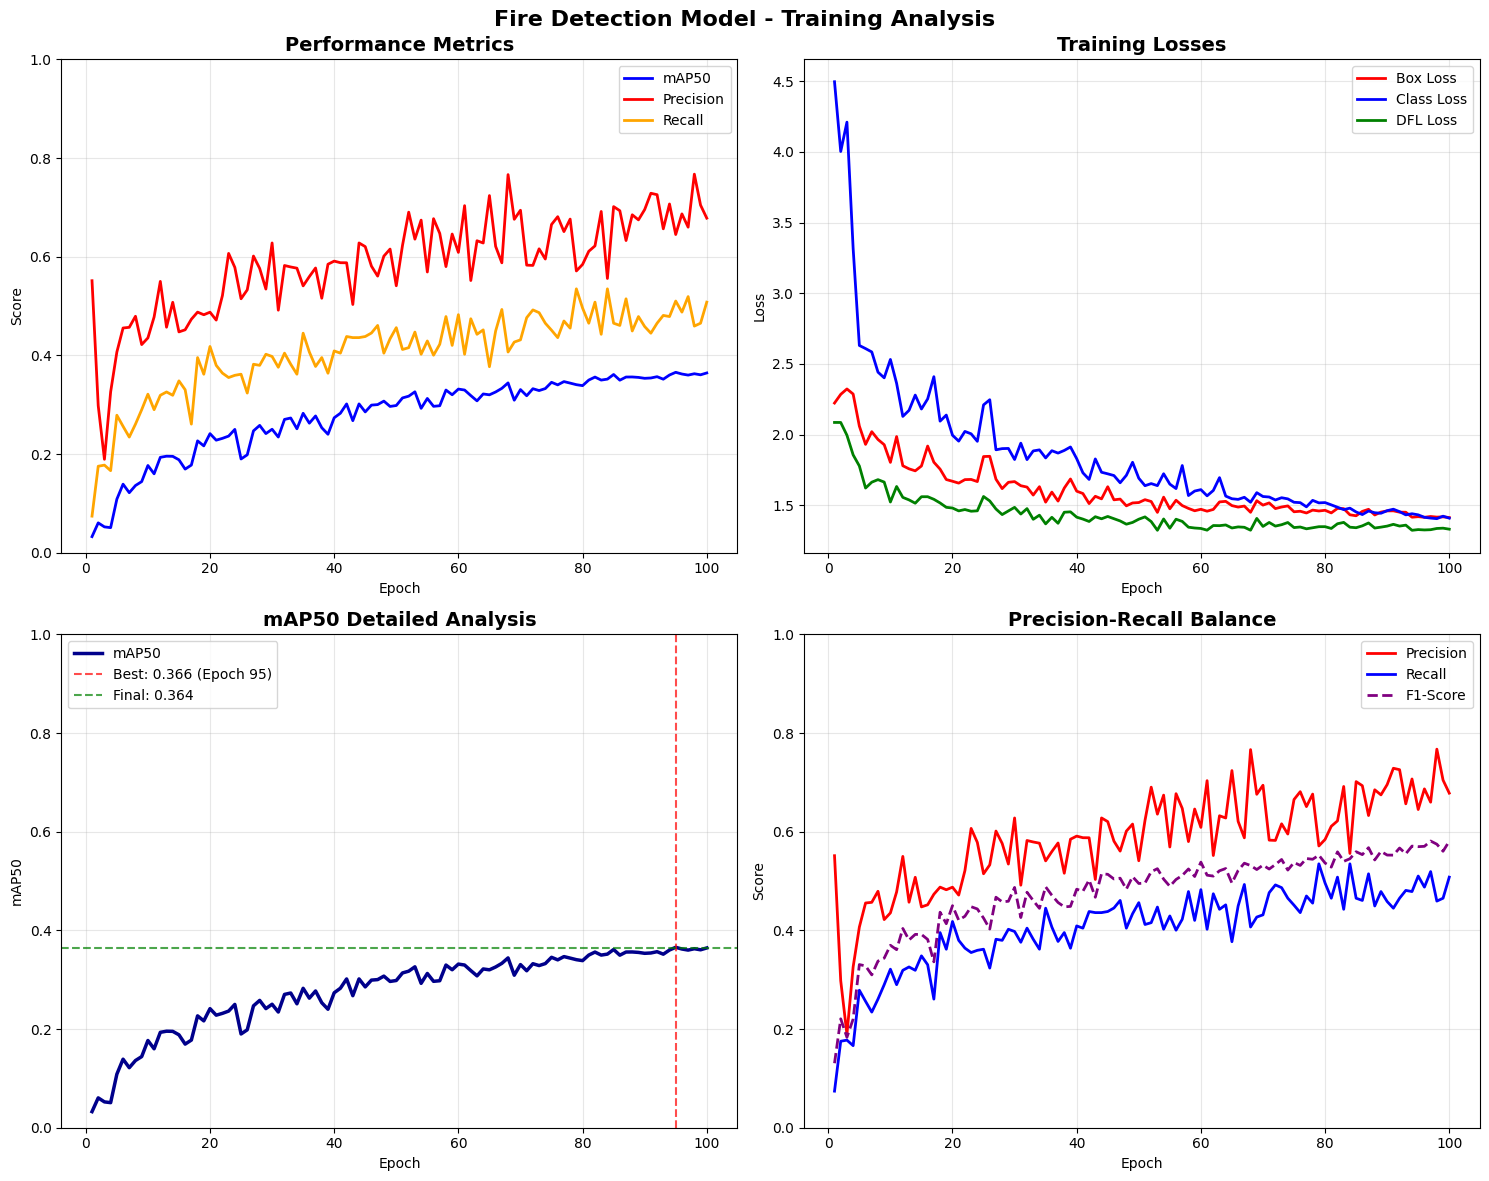

In [ ]:
def plot_training_curves():

    print("📊 PLOTTING TRAINING CURVES")
    print("=" * 50)

    results_csv = "runs/detect/fire_detection_final/results.csv"

    if not os.path.exists(results_csv):
        print("❌ Results CSV file not found")
        return

    df = pd.read_csv(results_csv)

    columns_mapping = {}
    for col in df.columns:
        col_lower = col.lower()
        if 'map50' in col_lower:
            columns_mapping['mAP50'] = col
        elif 'map' in col_lower and '50' not in col_lower:
            columns_mapping['mAP50-95'] = col
        elif 'precision' in col_lower:
            columns_mapping['precision'] = col
        elif 'recall' in col_lower:
            columns_mapping['recall'] = col
        elif 'box' in col_lower and 'loss' in col_lower:
            columns_mapping['box_loss'] = col
        elif 'cls' in col_lower and 'loss' in col_lower:
            columns_mapping['cls_loss'] = col
        elif 'dfl' in col_lower and 'loss' in col_lower:
            columns_mapping['dfl_loss'] = col

    print("📈 Columns found for plotting:")
    for key, value in columns_mapping.items():
        print(f"   ✅ {key}: {value}")

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Fire Detection Model - Training Analysis', fontsize=16, fontweight='bold')

    epochs = range(1, len(df) + 1)

    ax1 = axes[0, 0]
    if 'mAP50' in columns_mapping:
        ax1.plot(epochs, df[columns_mapping['mAP50']], label='mAP50', linewidth=2, color='blue')
    if 'mAP50-95' in columns_mapping:
        ax1.plot(epochs, df[columns_mapping['mAP50-95']], label='mAP50-95', linewidth=2, color='green')
    if 'precision' in columns_mapping:
        ax1.plot(epochs, df[columns_mapping['precision']], label='Precision', linewidth=2, color='red')
    if 'recall' in columns_mapping:
        ax1.plot(epochs, df[columns_mapping['recall']], label='Recall', linewidth=2, color='orange')

    ax1.set_title('Performance Metrics', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    ax2 = axes[0, 1]
    if 'box_loss' in columns_mapping:
        ax2.plot(epochs, df[columns_mapping['box_loss']], label='Box Loss', linewidth=2, color='red')
    if 'cls_loss' in columns_mapping:
        ax2.plot(epochs, df[columns_mapping['cls_loss']], label='Class Loss', linewidth=2, color='blue')
    if 'dfl_loss' in columns_mapping:
        ax2.plot(epochs, df[columns_mapping['dfl_loss']], label='DFL Loss', linewidth=2, color='green')

    ax2.set_title('Training Losses', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    
    ax3 = axes[1, 0]
    if 'mAP50' in columns_mapping:
        mAP50_values = df[columns_mapping['mAP50']]

     
        ax3.plot(epochs, mAP50_values, label='mAP50', linewidth=2.5, color='darkblue')

  
        best_epoch = mAP50_values.idxmax()
        best_value = mAP50_values.max()
        ax3.axvline(x=best_epoch + 1, color='red', linestyle='--', alpha=0.7,
                    label=f'Best: {best_value:.3f} (Epoch {best_epoch + 1})')

        final_value = mAP50_values.iloc[-1]
        ax3.axhline(y=final_value, color='green', linestyle='--', alpha=0.7,
                   label=f'Final: {final_value:.3f}')

        ax3.set_title('mAP50 Detailed Analysis', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('mAP50')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(0, 1)

    
    ax4 = axes[1, 1]
    if 'precision' in columns_mapping and 'recall' in columns_mapping:
        precision_values = df[columns_mapping['precision']]
        recall_values = df[columns_mapping['recall']]

        ax4.plot(epochs, precision_values, label='Precision', linewidth=2, color='red')
        ax4.plot(epochs, recall_values, label='Recall', linewidth=2, color='blue')


        f1_scores = 2 * (precision_values * recall_values) / (precision_values + recall_values + 1e-7)
        ax4.plot(epochs, f1_scores, label='F1-Score', linewidth=2, color='purple', linestyle='--')

        ax4.set_title('Precision-Recall Balance', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Score')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    return columns_mapping

columns_used = plot_training_curves()


📈 ADVANCED TRAINING ANALYSIS


/tmp/ipython-input-2450836282.py:91: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax3.boxplot(quarter_data, labels=quarter_labels, patch_artist=True)


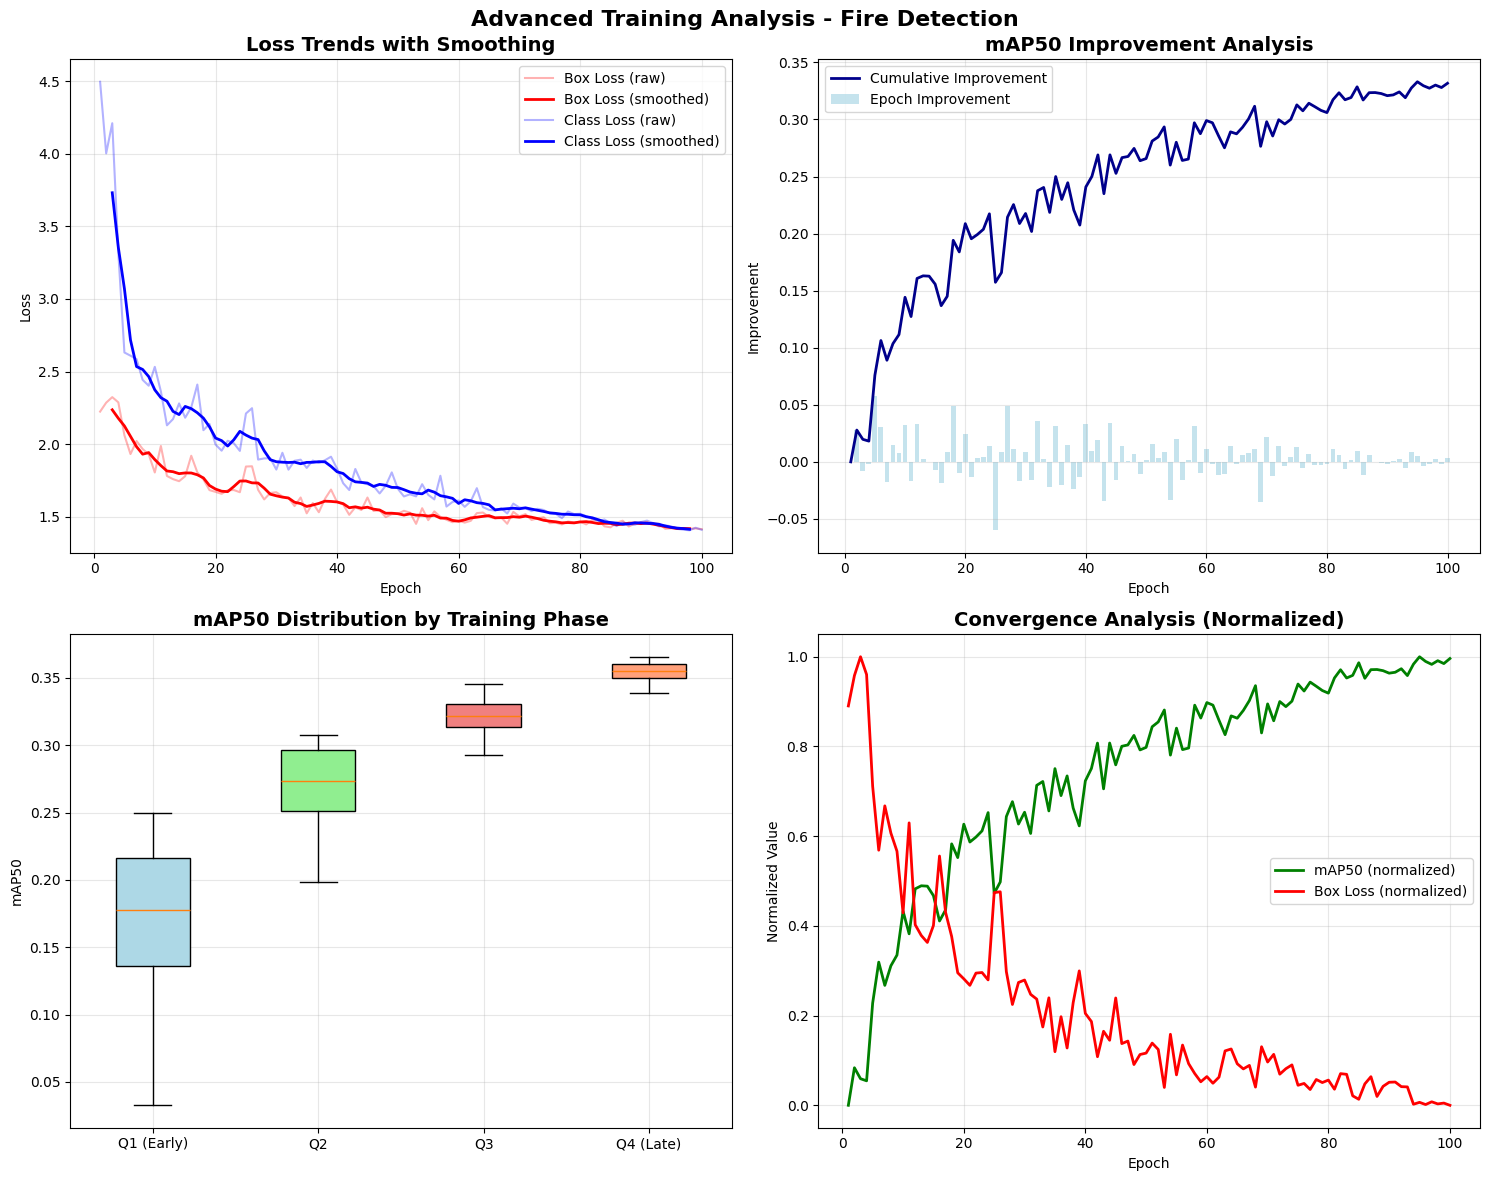

In [ ]:
def plot_advanced_analysis():
    print("\n📈 ADVANCED TRAINING ANALYSIS")
    print("=" * 50)

    results_csv = "runs/detect/fire_detection_final/results.csv"
    df = pd.read_csv(results_csv)

    columns_mapping = {}
    for col in df.columns:
        col_lower = col.lower()
        if 'map50' in col_lower:
            columns_mapping['mAP50'] = col
        elif 'box' in col_lower and 'loss' in col_lower:
            columns_mapping['box_loss'] = col
        elif 'cls' in col_lower and 'loss' in col_lower:
            columns_mapping['cls_loss'] = col

    if not columns_mapping:
        print("❌ No relevant columns found")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Advanced Training Analysis - Fire Detection', fontsize=16, fontweight='bold')

    epochs = range(1, len(df) + 1)

    ax1 = axes[0, 0]
    if 'box_loss' in columns_mapping and 'cls_loss' in columns_mapping:
        box_loss = df[columns_mapping['box_loss']]
        cls_loss = df[columns_mapping['cls_loss']]

        window = 5
        box_smooth = box_loss.rolling(window=window, center=True).mean()
        cls_smooth = cls_loss.rolling(window=window, center=True).mean()

        ax1.plot(epochs, box_loss, alpha=0.3, color='red', label='Box Loss (raw)')
        ax1.plot(epochs, box_smooth, linewidth=2, color='red', label='Box Loss (smoothed)')

        ax1.plot(epochs, cls_loss, alpha=0.3, color='blue', label='Class Loss (raw)')
        ax1.plot(epochs, cls_smooth, linewidth=2, color='blue', label='Class Loss (smoothed)')

        ax1.set_title('Loss Trends with Smoothing', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    if 'mAP50' in columns_mapping:
        mAP50 = df[columns_mapping['mAP50']]

        improvement = mAP50.diff().fillna(0)
        cumulative_improvement = mAP50 - mAP50.iloc[0]

        ax2.bar(epochs, improvement, alpha=0.7, color='lightblue', label='Epoch Improvement')
        ax2.plot(epochs, cumulative_improvement, linewidth=2, color='darkblue',
                label='Cumulative Improvement')

        ax2.set_title('mAP50 Improvement Analysis', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Improvement')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        ax3 = axes[1, 0]
    if 'mAP50' in columns_mapping:
        mAP50 = df[columns_mapping['mAP50']]

        quarter = len(df) // 4
        quarters = [
            ('Q1 (Early)', mAP50[:quarter]),
            ('Q2', mAP50[quarter:2*quarter]),
            ('Q3', mAP50[2*quarter:3*quarter]),
            ('Q4 (Late)', mAP50[3*quarter:])
        ]

        quarter_data = [q[1].values for q in quarters if len(q[1]) > 0]
        quarter_labels = [q[0] for q in quarters if len(q[1]) > 0]

        box_plot = ax3.boxplot(quarter_data, labels=quarter_labels, patch_artist=True)

        colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)

        ax3.set_title('mAP50 Distribution by Training Phase', fontsize=14, fontweight='bold')
        ax3.set_ylabel('mAP50')
        ax3.grid(True, alpha=0.3)

    ax4 = axes[1, 1]
    if 'mAP50' in columns_mapping and 'box_loss' in columns_mapping:
        mAP50 = df[columns_mapping['mAP50']]
        box_loss = df[columns_mapping['box_loss']]

        mAP50_norm = (mAP50 - mAP50.min()) / (mAP50.max() - mAP50.min())
        box_loss_norm = (box_loss - box_loss.min()) / (box_loss.max() - box_loss.min())

        ax4.plot(epochs, mAP50_norm, label='mAP50 (normalized)', linewidth=2, color='green')
        ax4.plot(epochs, box_loss_norm, label='Box Loss (normalized)', linewidth=2, color='red')

        ax4.set_title('Convergence Analysis (Normalized)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Normalized Value')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_advanced_analysis()

In [ ]:
def training_statistics_analysis():

    print("\n📊 DETAILED TRAINING STATISTICS")
    print("=" * 50)

    results_csv = "runs/detect/fire_detection_final/results.csv"
    df = pd.read_csv(results_csv)

    columns_mapping = {}
    for col in df.columns:
        col_lower = col.lower()
        if 'map50' in col_lower:
            columns_mapping['mAP50'] = col
        elif 'precision' in col_lower:
            columns_mapping['precision'] = col
        elif 'recall' in col_lower:
            columns_mapping['recall'] = col
        elif 'box' in col_lower and 'loss' in col_lower:
            columns_mapping['box_loss'] = col
        elif 'cls' in col_lower and 'loss' in col_lower:
            columns_mapping['cls_loss'] = col

    if not columns_mapping:
        print("❌ No relevant columns found for analysis")
        return

    print("📈 TRAINING STATISTICS SUMMARY:")
    print("-" * 40)

    for metric, col_name in columns_mapping.items():
        values = df[col_name]
        if len(values) > 0:
            print(f"\n🎯 {metric.upper()}:")
            print(f"   📍 Initial: {values.iloc[0]:.4f}")
            print(f"   📍 Final: {values.iloc[-1]:.4f}")
            print(f"   📍 Best: {values.max():.4f}")
            print(f"   📍 Average: {values.mean():.4f}")
            print(f"   📍 Std Dev: {values.std():.4f}")
            print(f"   📍 Improvement: {((values.iloc[-1] - values.iloc[0]) / values.iloc[0] * 100):.1f}%")

    if 'mAP50' in columns_mapping:
        mAP50 = df[columns_mapping['mAP50']]

        print(f"\n📉 STABILITY ANALYSIS:")
        print(f"   📊 Last 10 epochs std: {mAP50.tail(10).std():.4f}")
        print(f"   📊 Last 20 epochs std: {mAP50.tail(20).std():.4f}")

        last_10_trend = np.polyfit(range(10), mAP50.tail(10).values, 1)[0]
        print(f"   📈 Last 10 epochs trend: {last_10_trend:.4f}")

        if last_10_trend > 0.001:
            print("   ✅ Still improving at the end")
        elif abs(last_10_trend) <= 0.001:
            print("   ⚖️ Stable at the end")
        else:
            print("   ⚠️ Slight degradation at the end")

training_statistics_analysis()


📊 DETAILED TRAINING STATISTICS
📈 TRAINING STATISTICS SUMMARY:
----------------------------------------

🎯 BOX_LOSS:
   📍 Initial: 2.2237
   📍 Final: 1.4140
   📍 Best: 2.3234
   📍 Average: 1.6071
   📍 Std Dev: 0.2062
   📍 Improvement: -36.4%

🎯 CLS_LOSS:
   📍 Initial: 4.4967
   📍 Final: 1.4093
   📍 Best: 4.4967
   📍 Average: 1.8569
   📍 Std Dev: 0.5474
   📍 Improvement: -68.7%

🎯 PRECISION:
   📍 Initial: 0.5513
   📍 Final: 0.6781
   📍 Best: 0.7673
   📍 Average: 0.5849
   📍 Std Dev: 0.0993
   📍 Improvement: 23.0%

🎯 RECALL:
   📍 Initial: 0.0742
   📍 Final: 0.5079
   📍 Best: 0.5348
   📍 Average: 0.4061
   📍 Std Dev: 0.0841
   📍 Improvement: 584.8%

🎯 MAP50:
   📍 Initial: 0.0326
   📍 Final: 0.3644
   📍 Best: 0.3657
   📍 Average: 0.2776
   📍 Std Dev: 0.0800
   📍 Improvement: 1016.6%

📉 STABILITY ANALYSIS:
   📊 Last 10 epochs std: 0.0044
   📊 Last 20 epochs std: 0.0050
   📈 Last 10 epochs trend: 0.0010
   ✅ Still improving at the end



🎯 FINAL VISUAL TRAINING REPORT


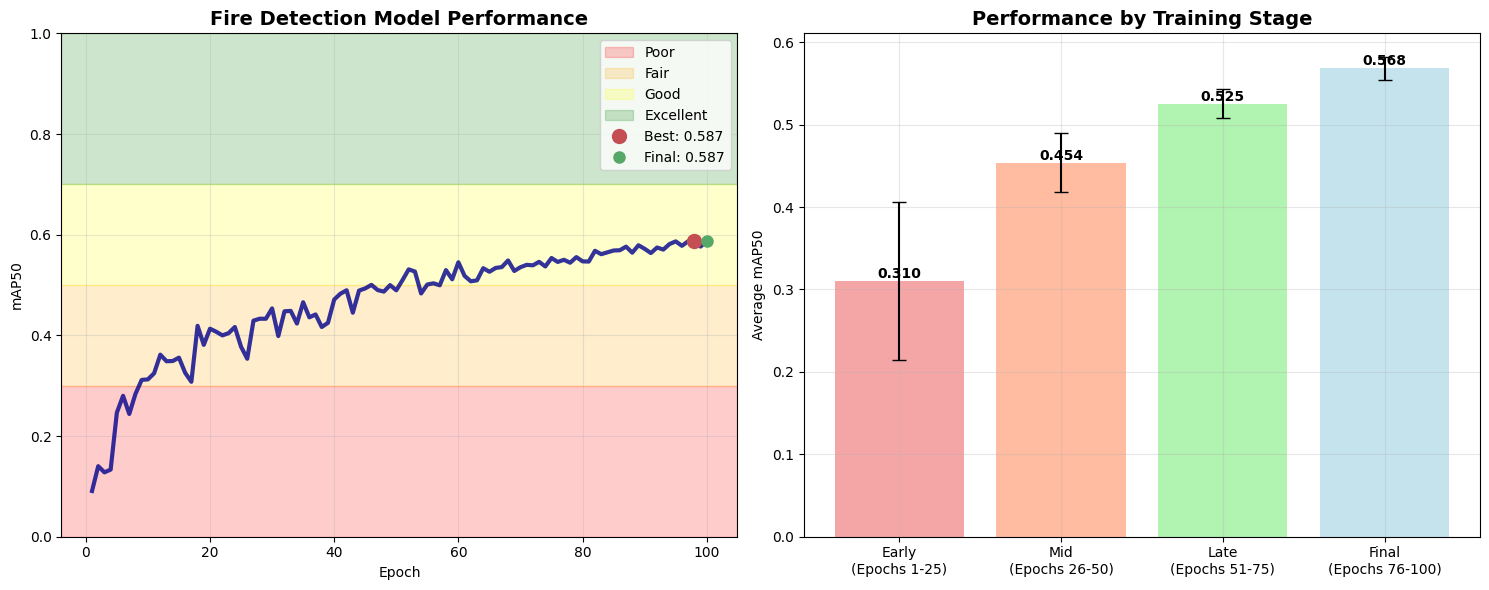


📊 FINAL PERFORMANCE ASSESSMENT:
   🎯 Best mAP50: 0.587 (Epoch 98)
   📍 Final mAP50: 0.587
   📈 Overall Improvement: 546.2%
   👍 GOOD: Suitable for most applications


In [ ]:
def final_visual_report():

    print("\n🎯 FINAL VISUAL TRAINING REPORT")
    print("=" * 60)

    results_csv = "runs/detect/fire_detection_final/results.csv"
    df = pd.read_csv(results_csv)

    mAP50_col = None
    for col in df.columns:
        if 'map50' in col.lower() or 'mAP50' in col:
            mAP50_col = col
            break

    if not mAP50_col:
        print("❌ mAP50 column not found")
        return

    mAP50_values = df[mAP50_col]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    ax1 = axes[0]
    epochs = range(1, len(df) + 1)

    ax1.plot(epochs, mAP50_values, linewidth=3, color='darkblue', alpha=0.8)

    ax1.axhspan(0, 0.3, alpha=0.2, color='red', label='Poor')
    ax1.axhspan(0.3, 0.5, alpha=0.2, color='orange', label='Fair')
    ax1.axhspan(0.5, 0.7, alpha=0.2, color='yellow', label='Good')
    ax1.axhspan(0.7, 1.0, alpha=0.2, color='green', label='Excellent')

    best_epoch = mAP50_values.idxmax()
    best_value = mAP50_values.max()
    ax1.plot(best_epoch + 1, best_value, 'ro', markersize=10, label=f'Best: {best_value:.3f}')

    final_value = mAP50_values.iloc[-1]
    ax1.plot(len(df), final_value, 'go', markersize=8, label=f'Final: {final_value:.3f}')

    ax1.set_title('Fire Detection Model Performance', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('mAP50')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    ax2 = axes[1]

    stages = {
        'Early\n(Epochs 1-25)': mAP50_values[:25],
        'Mid\n(Epochs 26-50)': mAP50_values[25:50],
        'Late\n(Epochs 51-75)': mAP50_values[50:75],
        'Final\n(Epochs 76-100)': mAP50_values[75:]
    }

    stage_data = [stage.values for stage in stages.values() if len(stage) > 0]
    stage_labels = list(stages.keys())[:len(stage_data)]

    bars = ax2.bar(stage_labels, [np.mean(stage) for stage in stage_data],
                   color=['lightcoral', 'lightsalmon', 'lightgreen', 'lightblue'],
                   alpha=0.7)

    for i, (label, stage) in enumerate(stages.items()):
        if i < len(stage_data):
            ax2.errorbar(i, np.mean(stage), yerr=np.std(stage),
                        fmt='none', color='black', capsize=5)

    ax2.set_title('Performance by Training Stage', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Average mAP50')
    ax2.grid(True, alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f"\n📊 FINAL PERFORMANCE ASSESSMENT:")
    print(f"   🎯 Best mAP50: {best_value:.3f} (Epoch {best_epoch + 1})")
    print(f"   📍 Final mAP50: {final_value:.3f}")
    print(f"   📈 Overall Improvement: {((final_value - mAP50_values.iloc[0]) / mAP50_values.iloc[0] * 100):.1f}%")

    if final_value >= 0.7:
        print("   🏆 EXCELLENT: Ready for production deployment")
    elif final_value >= 0.5:
        print("   👍 GOOD: Suitable for most applications")
    elif final_value >= 0.3:
        print("   ⚠️ FAIR: Needs improvement for critical applications")
    else:
        print("   🔴 POOR: Requires significant improvement")

final_visual_report()